In [1]:
import math

import matplotlib.pyplot as plt
import numpy as np
from numpy import random

In [2]:
from filters import kalman, kalman_ekf, kalman_ukf, sigma_points
from models import const_acc, const_vel, noise
from plots import plot_common
from simulators import radar, robot, trajectory

## Tracking a Ball


### No friction


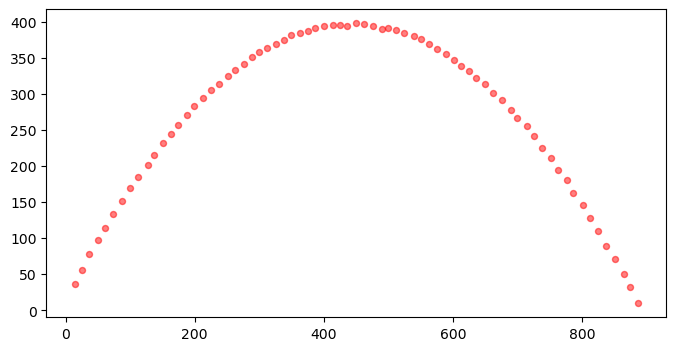

In [3]:
def test_ball_vacuum(noise, ax):
    y = 15
    x = 0
    ball = trajectory.BallTrajectory2D(
        x0=x, y0=y, theta_deg=60.0, vel=100.0, noise=noise
    )
    t = 0
    dt = 0.25
    while y >= 0:
        x, y = ball.step(dt)
        t += dt
        if y >= 0:
            ax.scatter(x, y, color="r", marker=".", s=75, alpha=0.5)


_, ax = plt.subplots(figsize=(8, 4))
test_ball_vacuum([1, 1], ax)

In [4]:
def ball_kf(x, y, omega, v0, dt, r=0.5, q=0.0):
    kf = kalman.KalmanFilter(dim_x=4, dim_z=2, dim_u=1)
    kf.F = const_vel.FCV(4, dt)
    kf.H = np.array([[1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0]])
    kf.G = np.array([[0.0, 0.0, 0.0, dt]]).T
    kf.R *= r
    kf.Q *= q
    omega = math.radians(omega)
    vx = math.cos(omega) * v0
    vy = math.sin(omega) * v0
    kf.x = np.array([[x, vx, y, vy]]).T
    return kf

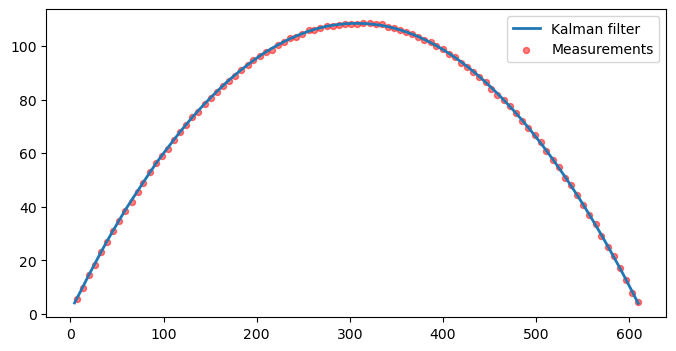

In [5]:
def track_ball_vacuum(dt, ax):
    global kf
    x, y = 0.0, 1.0
    theta = 35.0  # launch angle
    v0 = 80.0
    g = np.array([[-9.8]])
    ball = trajectory.BallTrajectory2D(
        x0=x, y0=y, theta_deg=theta, vel=v0, noise=[0.2, 0.2]
    )
    kf = ball_kf(x, y, theta, v0, dt)
    t = 0
    xs, ys = [], []
    while kf.x[2] > 0:
        t += dt
        x, y = ball.step(dt)
        z = np.array([[x, y]]).T
        kf.update(z)
        xs.append(kf.x[0])
        ys.append(kf.x[2])
        kf.predict(u=g)
        p1 = ax.scatter(x, y, color="r", marker=".", s=75, alpha=0.5)

    (p2,) = ax.plot(xs, ys, lw=2)
    ax.legend([p2, p1], ["Kalman filter", "Measurements"])


_, ax = plt.subplots(figsize=(8, 4))
track_ball_vacuum(dt=1.0 / 10, ax=ax)

### With friction


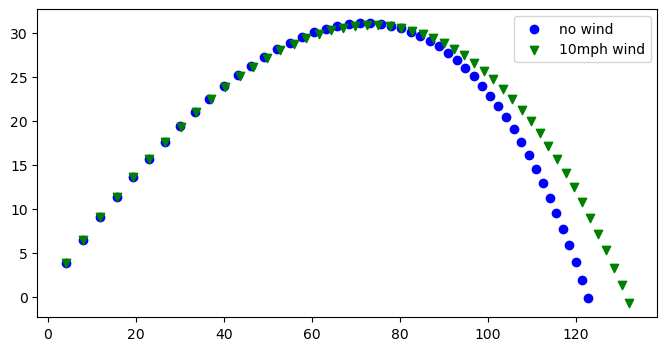

In [6]:
def mph_to_mps(x):
    return x * 0.447


def drag_force(velocity):
    """Returns the force on a baseball due to air drag at the specified velocity. Units are SI"""
    return velocity * (0.0039 + 0.0058 / (1.0 + math.exp((velocity - 35.0) / 5.0)))


v = mph_to_mps(110.0)
x, y = 0.0, 1.0
dt = 0.1
theta = math.radians(35)


def solve(x, y, vel, v_wind, launch_angle):
    xs = []
    ys = []
    v_x = vel * math.cos(launch_angle)
    v_y = vel * math.sin(launch_angle)
    while y >= 0:
        # Euler equations for x and y
        x += v_x * dt
        y += v_y * dt
        # force due to air drag
        velocity = np.sqrt((v_x - v_wind) ** 2 + v_y**2)
        F = drag_force(velocity)
        # euler's equations for vx and vy
        v_x = v_x - F * (v_x - v_wind) * dt
        v_y = v_y - 9.8 * dt - F * v_y * dt
        xs.append(x)
        ys.append(y)

    return xs, ys


x, y = solve(x=0, y=1, vel=v, v_wind=0, launch_angle=theta)

_, ax = plt.subplots(figsize=(8, 4))

ax.scatter(x, y, color="blue", label="no wind")
wind = mph_to_mps(10)
x, y = solve(x=0, y=1, vel=v, v_wind=wind, launch_angle=theta)
ax.scatter(x, y, color="green", marker="v", label="10mph wind")
ax.legend()

# plt.savefig("../images/trk-parabola.png")

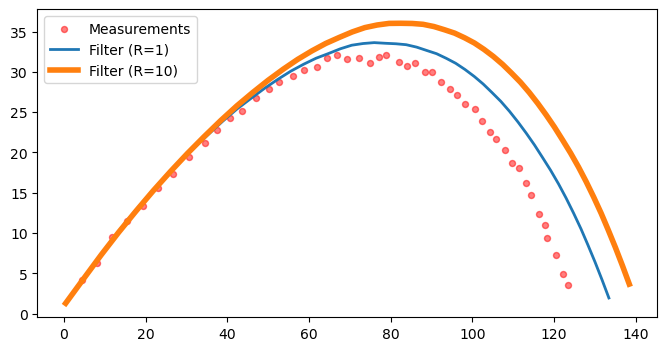

In [7]:
x, y = 0, 1.0
θ = 35.0  # launch angle
v0 = 50.0
dt = 1 / 10.0
g = np.array([[-9.8]])

ball = trajectory.BaseballPath(
    x0=x, y0=y, launch_angle_deg=θ, vel_ms=v0, noise=[0.3, 0.3]
)

f1 = ball_kf(x, y, θ, v0, dt, r=1.0)
f2 = ball_kf(x, y, θ, v0, dt, r=10.0)
t = 0
xs, ys = [], []
xs2, ys2 = [], []

_, ax = plt.subplots(figsize=(8, 4))

while f1.x[2] > 0:
    t += dt
    x, y = ball.update(dt)
    z = np.array([[x, y]]).T
    f1.update(z)
    f2.update(z)
    xs.append(f1.x[0])
    ys.append(f1.x[2])
    xs2.append(f2.x[0])
    ys2.append(f2.x[2])
    f1.predict(u=g)
    f2.predict(u=g)
    p1 = ax.scatter(x, y, color="r", marker=".", s=75, alpha=0.5)

(p2,) = ax.plot(xs, ys, lw=2)
(p3,) = ax.plot(xs2, ys2, lw=4)
ax.legend([p1, p2, p3], ["Measurements", "Filter (R=1)", "Filter (R=10)"], loc="best")

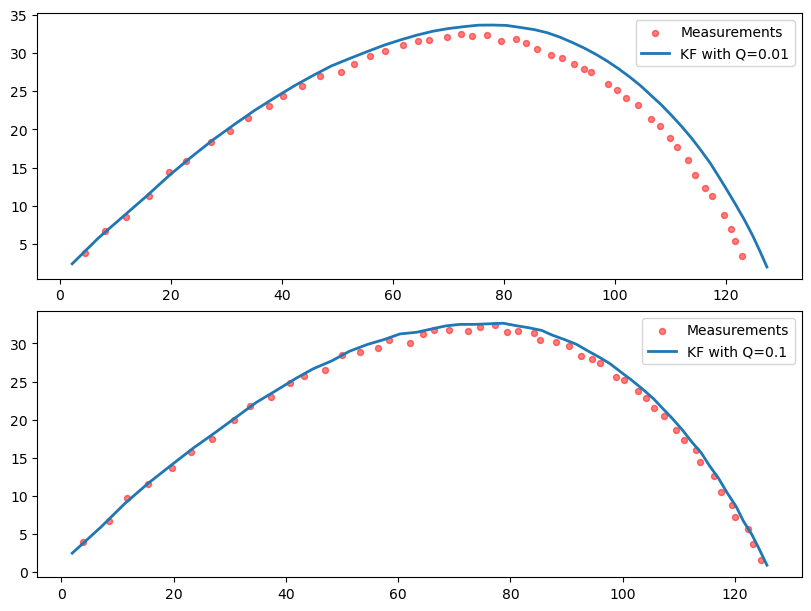

In [8]:
def plot_ball_with_q(ax, q, r=1.0, noise=0.3):
    x, y = 0.0, 1.0
    θ = 35.0  # launch angle
    v0 = 50.0
    dt = 1 / 10.0
    g = np.array([[-9.8]])
    ball = trajectory.BaseballPath(
        x0=x, y0=y, launch_angle_deg=θ, vel_ms=v0, noise=[noise, noise]
    )
    f1 = ball_kf(x, y, θ, v0, dt, r=r, q=q)
    t = 0
    xs, ys = [], []
    while f1.x[2] > 0:
        t += dt
        x, y = ball.update(dt)
        z = np.array([[x, y]]).T
        f1.update(z)
        xs.append(f1.x[0])
        ys.append(f1.x[2])
        f1.predict(u=g)
        p1 = ax.scatter(x, y, c="r", marker=".", s=75, alpha=0.5)
    (p2,) = ax.plot(xs, ys, lw=2)
    ax.legend([p1, p2], ["Measurements", f"KF with Q={q}"])


_, axes = plt.subplots(2, 1, figsize=(8, 6), constrained_layout=True)

plot_ball_with_q(axes[0], 0.01)
plot_ball_with_q(axes[1], 0.1)

# plt.savefig("../images/trk-parabola-q.png")

## Explain Filter Performance


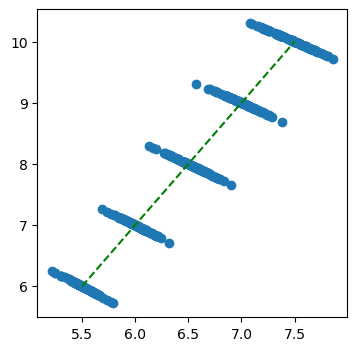

In [9]:
_, ax = plt.subplots(figsize=(4, 4))

radar.plot_moving_target(ax)
# plt.savefig('../images/radar-moving-target.png')

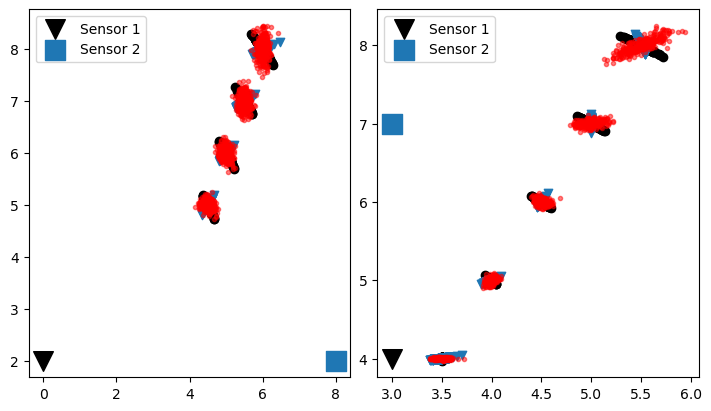

In [10]:
_, axes = plt.subplots(1, 2, figsize=(7, 4), constrained_layout=True)

radar.plot_iscts_two_sensors(axes)
# plt.savefig('../images/radar-two-sensors.png')

## Tracking an Airplane


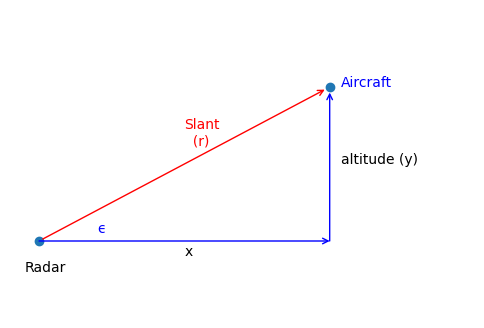

In [11]:
fig, ax = plt.subplots(figsize=(6, 4))

radar.show_radar_chart(ax)

# plt.savefig("../images/radar.png", bbox_inches="tight", pad_inches=-0.1)

### UKF


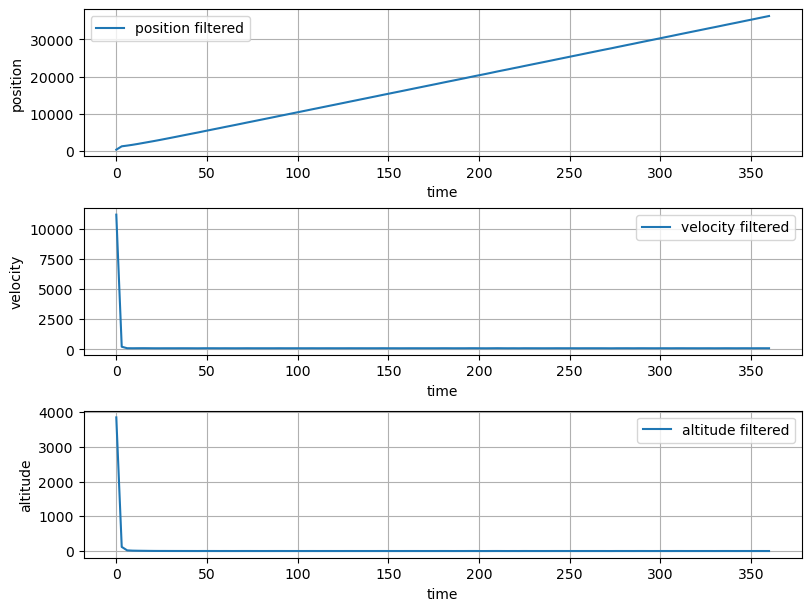

In [12]:
dt = 3.0
range_std = 5
elev_std = math.radians(0.5)
radar_pos = (0.0, 0.0)

points = sigma_points.MerweScaledSigmas(n=3, kappa=0.0, alpha=0.1, beta=2.0)
ukf = kalman_ukf.UnscentedKalmanFilter(
    3, 2, dt, fx=const_acc.FxCA, hx=radar.H3dRE, points=points
)
ukf.P = np.diag([300**2, 30**2, 150**2])
ukf.Q[0:2, 0:2] = noise.white_noise_discrete(2, dt=dt, var=0.1)
ukf.Q[2, 2] = 0.1
ukf.R = np.diag([range_std**2, elev_std**2])
ukf.x = np.array([0.0, 90.0, 1100.0])

np.random.seed(200)
pos = (0, 0)
radarr = radar.RadarStation(pos, range_std, elev_std)

pos_acc = (0.0, 1000.0)
vel_acc = (100.0, 0.0)
acc = radar.ACSim(pos_acc, vel_acc, 0.02)

time = np.arange(0, 360 + dt, dt)
xs = np.zeros((len(time), 3))
for idx, _ in enumerate(time):
    acc.update(dt)
    r = radarr.noisy_reading(acc.pos)
    ukf.predict()
    ukf.update([r[0], r[1]], refpos=pos)
    xs[idx] = np.array(ukf.x)

_, axes = plt.subplots(3, 1, figsize=(8, 6), constrained_layout=True)

radar.plot_radar3d(axes, time, xs)

### Tracking Maneuevering Aircraft


Actual altitude: 2514.6
UKF altitude : 2596.7


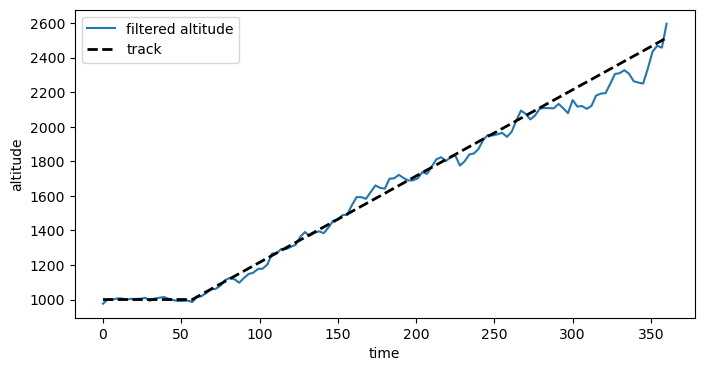

In [13]:
def UKF_cv(fx, hx, dt, R_std):
    points = sigma_points.MerweScaledSigmas(n=4, kappa=-1.0, alpha=0.1, beta=2.0)
    kf = kalman_ukf.UnscentedKalmanFilter(
        4, len(R_std), dt, fx=fx, hx=hx, points=points
    )
    kf.Q[0:2, 0:2] = noise.white_noise_discrete(2, dt=dt, var=0.1)
    kf.Q[2:4, 2:4] = noise.white_noise_discrete(2, dt=dt, var=0.1)
    kf.R = np.dot(np.diag(R_std), np.diag(R_std))
    kf.x = np.array([0.0, 90.0, 1100.0, 0.0])
    kf.P = np.diag([300**2, 3**2, 150**2, 3**2])
    return kf


np.random.seed(200)
pos_acc = (0.0, 1000.0)
vel_acc = (100.0, 0.0)
radar_pos = (0.0, 0.0)
acc = radar.ACSim(pos_acc, vel_acc, 0.02)

dt = 3.0  # 12 seconds between readings
range_std = 5
elev_std = math.radians(0.5)
kf_cv = UKF_cv(const_vel.FxCV, radar.H3dRE, dt, R_std=[range_std, elev_std])

time = np.arange(0, 360 + dt, dt)
xs, ys = [], []
for t in time:
    if t >= 60:
        acc.vel[1] = 300 / 60  # 300 m/min climb
    acc.update(dt)
    r = radarr.noisy_reading(acc.pos)
    ys.append(acc.pos[1])
    kf_cv.predict()
    kf_cv.update([r[0], r[1]], refpos=radar_pos)
    xs.append(kf_cv.x)

_, ax = plt.subplots(figsize=(8, 4))

radar.plot_radar3d_zs(ax, time, xs, obj="altitude", track=ys)
print(f"Actual altitude: {acc.pos[1]:.1f}")
print(f"UKF altitude : {xs[-1][2]:.1f}")

Velocity std 3.2 m/s


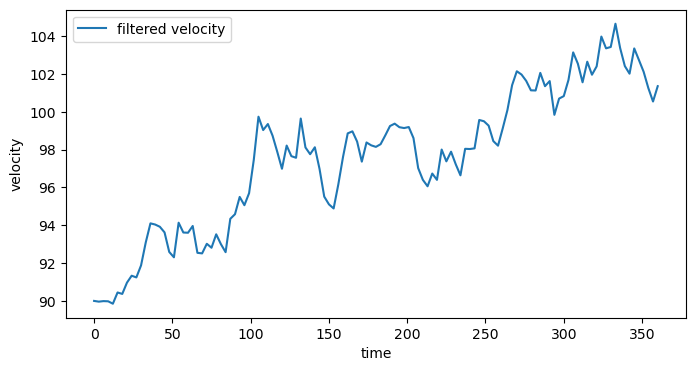

In [14]:
range_std = 500.0
elev_std = math.degrees(0.5)

np.random.seed(200)

radar_pos = (0, 0)
pos_acc = (0.0, 1000.0)
vel_acc = (100.0, 0.0)
radarr = radar.RadarStation(radar_pos, range_std, elev_std)
acc = radar.ACSim(pos_acc, vel_acc, 0.02)

kf_sf = UKF_cv(const_vel.FxCV, radar.H3dRE, dt=dt, R_std=[range_std, elev_std])
time = np.arange(0, 360 + dt, dt)

xs = []
for _ in time:
    acc.update(dt)
    r = radarr.noisy_reading(acc.pos)
    kf_sf.predict()
    kf_sf.update([r[0], r[1]], refpos=radar_pos)
    xs.append(kf_sf.x)

xs = np.asarray(xs)

_, ax = plt.subplots(figsize=(8, 4))

radar.plot_radar3d_zs(ax, time, xs, obj="velocity")
print(f"Velocity std {np.std(xs[10:, 1]):.1f} m/s")

Velocity std 0.9 m/s


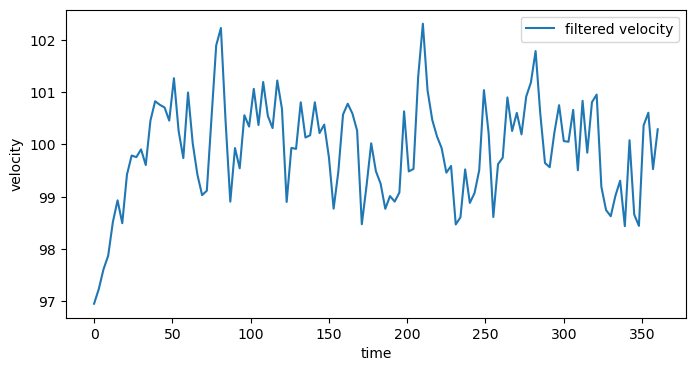

In [15]:
range_std = 500.0
elev_std = math.degrees(0.5)
vel_std = 2.0

np.random.seed(200)
ac = radar.ACSim(pos_acc, vel_acc, 0.02)
radarr = radar.RadarStation((0, 0), range_std, elev_std)
kf_sf2 = UKF_cv(
    const_vel.FxCV,
    radar.H4dRE,
    dt=dt,
    R_std=[range_std, elev_std, vel_std, vel_std],
)

time = np.arange(0, 360 + dt, dt)
xs = []
for _ in time:
    ac.update(dt)
    r = radarr.noisy_reading(ac.pos)
    # simulate the doppler velocity reading
    vx = ac.vel[0] + random.randn() * vel_std
    vz = ac.vel[1] + random.randn() * vel_std
    kf_sf2.predict()
    kf_sf2.update([r[0], r[1], vx, vz], refpos=radar_pos)
    xs.append(kf_sf2.x)

xs = np.asarray(xs)

_, ax = plt.subplots(figsize=(8, 4))

radar.plot_radar3d_zs(ax, time, xs, obj="velocity")
print(f"Velocity std {np.std(xs[10:, 1]):.1f} m/s")

### EKF


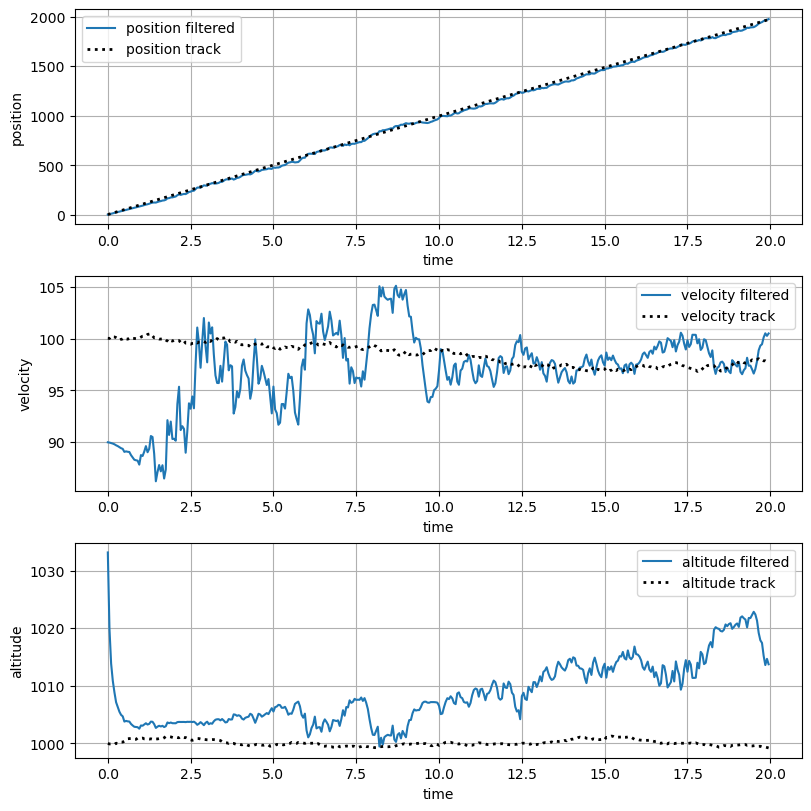

In [16]:
np.random.seed(200)

dt = 0.05
efk = kalman_ekf.ExtendedKalmanFilter(dim_x=3, dim_z=1)
radarr = radar.RadarSim(dt, pos=0.0, vel=100.0, alt=1000.0)

# make an imperfect starting guess
efk.F = np.eye(3) + np.array([[0, 1, 0], [0, 0, 0], [0, 0, 0]]) * dt
efk.x = np.array([radarr.pos, radarr.vel - 10, radarr.alt + 100])

range_std = 5.0
efk.R = np.diag([range_std**2])
efk.Q[0:2, 0:2] = noise.white_noise_discrete(2, dt=dt, var=0.1)
efk.Q[2, 2] = 0.1
efk.P *= 50

time = int(20 / dt)

xs = np.zeros((time, 3))
track = np.zeros((time, 3))
for idx in range(time):
    z = radarr.get_range()
    track[idx] = [radarr.pos, radarr.vel, radarr.alt]

    efk.predict()
    efk.update(np.array([z]), radar.HJac3d, radar.hx)
    xs[idx] = efk.x

xs = np.array(xs)
track = np.array(track)
time = np.arange(0, len(xs) * dt, dt)

_, axes = plt.subplots(3, 1, figsize=(8, 8), constrained_layout=True)

radar.plot_radar3d(axes, time, xs, track=track)

## Robot Localization


In [17]:
def show_bicycle_chart(ax):
    # ax.add_patch(plt.Rectangle((10,0), 10, 20,  fill=False, ec='k')) #car
    ax.add_patch(plt.Rectangle((17, 1), 0.70, 1.6, fill=False, ec="k"))
    # slant rectangle
    ax.add_patch(plt.Rectangle((17.33, 7.3), 0.70, 1.6, fill=False, ec="k", angle=26.5))
    # slant angle
    ax.plot([17.375, 16.25], [8, 10.5], color="k", lw=1)
    ax.plot([17.375, 17.125], [8, 10.5], color="k", lw=1)

    # direction arrow
    ax.arrow(17.375, 2.0, 0, 5.8, fc="k", ec="k", head_width=0.3, head_length=0.5)
    ax.text(16.7, 9.75, "α", fontsize="medium")
    ax.text(12.3, 8, "w (wheelbase)", fontsize="medium")

    # direction rectangle
    ax.add_patch(
        plt.Rectangle(
            (17.0, 4.0), 0.70, 1.6, fill=True, ec="k", angle=5, ls="dashdot", alpha=0.3
        )
    )
    ax.arrow(18.375, 2, 0, 2.5, fc="k", ec="k", head_width=0.3, head_length=0.5)
    ax.text(19, 3, "d", fontsize="medium")

    # ax.add_patch(plt.Rectangle((10,0), 10, 20,  fill=False, ec='k'))
    ax.text(11, 1.0, "R", fontsize="medium")

    ax.text(0, 1, "C", fontsize="medium")

    ax.text(8, 2.4, "β", fontsize="medium")
    ax.arrow(0, 2, 16.4, 3, fc="k", ec="k", head_width=0.3, head_length=0.5)
    ax.arrow(0, 2, 16.5, 0, fc="k", ec="k", head_width=0.3, head_length=0.5)

    ax.axis("scaled")
    ax.axis("off")
    # ax.set(xlim=(0, 25))

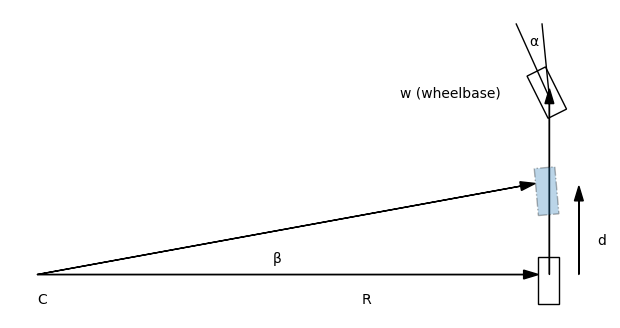

In [18]:
_, ax = plt.subplots(figsize=(8, 4))

show_bicycle_chart(ax)
# plt.savefig("../images/model-bicycle.png")

### UKF


In [19]:
def plot_cov_ellipse_initial(ax, x, P, std_ellipse, facecolor, alpha):
    plot_common.plot_cov_ellipse(
        ax,
        (x[0], x[1]),
        P[0:2, 0:2],
        stds=std_ellipse,
        facecolor=facecolor,
        alpha=alpha,
        title=False,
    )


def plot_local_ukf(
    ax,
    dt,
    wheelbase,
    cmds,
    landmarks,
    std_vel,
    std_steer,
    std_range,
    std_bearing,
    std_ellipse=None,
    ellipse_step=1,
    step=10,
):
    if std_ellipse is None:
        std_ellipse = [6]
    points = sigma_points.MerweScaledSigmas(
        n=3, alpha=0.00001, beta=2, kappa=0, subtract_method=robot.residual_x
    )

    ukf = kalman_ukf.UnscentedKalmanFilter(
        dim_x=3,
        dim_z=2 * len(landmarks),
        fx=robot.robot_move,
        hx=robot.Hx,
        dt=dt,
        points=points,
        x_mean_fn=robot.state_mean,
        z_mean_fn=robot.z_mean,
        residual_x=robot.residual_x,
        residual_z=robot.residual_h,
    )

    ukf.x = np.array([2, 6, 0.3])
    ukf.P = np.diag([0.1, 0.1, 0.05])
    ukf.R = np.diag([std_range**2, std_bearing**2] * len(landmarks))
    ukf.Q = np.eye(3) * 0.0001
    sim_pos = ukf.x.copy()

    # plot landmarks
    if len(landmarks) > 0:
        ax.scatter(landmarks[:, 0], landmarks[:, 1], marker="s", s=60)

    track = []
    for i, u in enumerate(cmds):
        sim_pos = robot.robot_move(sim_pos, dt / step, u, wheelbase)
        track.append(sim_pos)

        if i % step == 0:
            ukf.predict(u=u, wheelbase=wheelbase)

            if i % ellipse_step == 0:
                plot_cov_ellipse_initial(ax, ukf.x, ukf.P, std_ellipse, "k", 0.3)

            x, y = sim_pos[0], sim_pos[1]
            z = []
            for lmark in landmarks:
                dx, dy = lmark[0] - x, lmark[1] - y
                dist = np.hypot(dx, dy) + random.randn() * std_range
                bearing = math.atan2(dy, dx)
                angle = robot.normalize_angle(
                    bearing - sim_pos[2] + random.randn() * std_bearing
                )
                z += [dist, angle]

            ukf.update(z, landmarks=landmarks)

            if i % ellipse_step == 0:
                plot_cov_ellipse_initial(ax, ukf.x, ukf.P, std_ellipse, "g", 0.8)

    track = np.array(track)
    ax.plot(track[:, 0], track[:, 1], color="k", lw=2)
    ax.set(title=f"Robot local in {ellipse_step} steps with {len(landmarks)} landmarks")

    return ukf

Final P: [0.00858152 0.01795294 0.00062296]


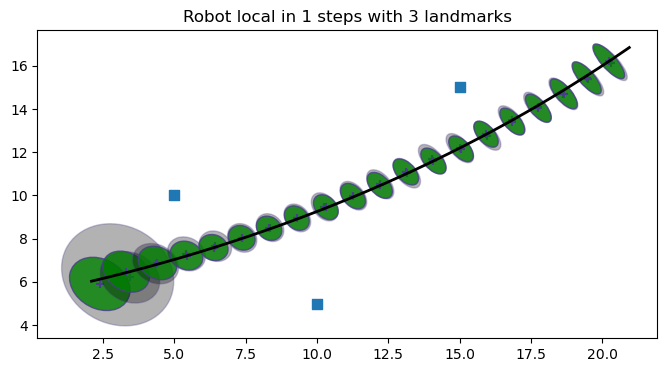

In [20]:
dt = 1.0
wheelbase = 0.5
landmarks = np.array([[5, 10], [10, 5], [15, 15]])
cmds = [np.array([1.1, 0.01])] * 200

_, ax = plt.subplots(figsize=(8, 4))

ukf = plot_local_ukf(
    ax,
    dt,
    wheelbase,
    cmds,
    landmarks,
    std_vel=0.1,
    std_steer=np.radians(1),
    std_range=0.3,
    std_bearing=0.1,
    std_ellipse=[6],
)
print("Final P:", ukf.P.diagonal())

final covariance [0.00115148 0.00418714 0.00033528]
final covariance [0.00249785 0.0652668  0.00068468]


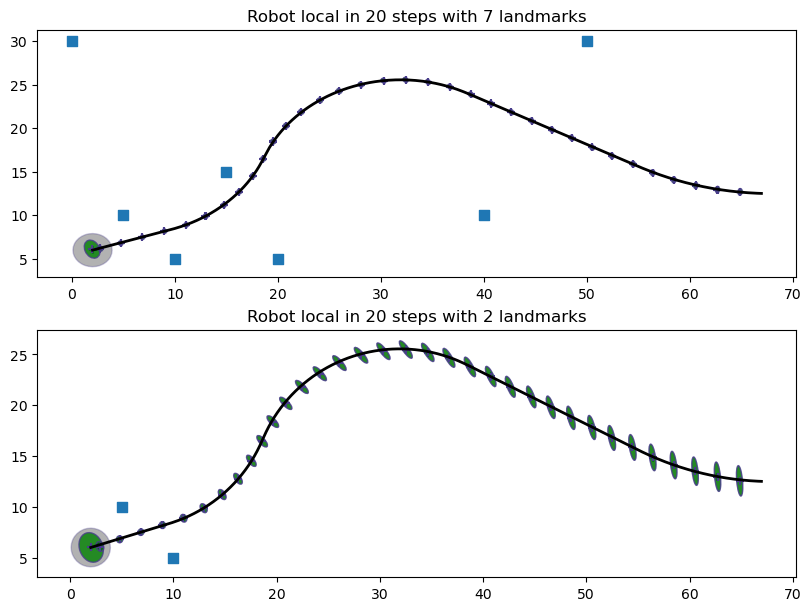

In [21]:
landmarks = np.array([[5, 10], [10, 5], [15, 15], [20, 5], [0, 30], [50, 30], [40, 10]])

dt = 0.1
wheelbase = 0.5
sigma_range = 0.3
sigma_bearing = 0.1

cmds = [[v, 0.0] for v in np.linspace(0.001, 1.1, 30)]
cmds += [cmds[-1]] * 50
# turn left
v = cmds[-1][0]
cmds += robot.robot_turn(v, 0, 2, 15)

cmds += [cmds[-1]] * 100
# turn right
cmds += robot.robot_turn(v, 2, -2, 15)
cmds += [cmds[-1]] * 200
cmds += robot.robot_turn(v, -2, 0, 15)
cmds += [cmds[-1]] * 150
cmds += robot.robot_turn(v, 0, 1, 25)
cmds += [cmds[-1]] * 100

_, axes = plt.subplots(2, 1, figsize=(8, 6), constrained_layout=True)

ukf = plot_local_ukf(
    axes[0],
    dt,
    wheelbase,
    cmds,
    landmarks,
    std_vel=0.1,
    std_steer=np.radians(1),
    std_range=0.3,
    std_bearing=0.1,
    std_ellipse=[6],
    step=1,
    ellipse_step=20,
)

print("final covariance", ukf.P.diagonal())

ukf = plot_local_ukf(
    axes[1],
    dt,
    wheelbase,
    cmds,
    landmarks[:2],
    std_vel=0.1,
    std_steer=np.radians(1),
    std_range=0.3,
    std_bearing=0.1,
    std_ellipse=[6],
    step=1,
    ellipse_step=20,
)
print("final covariance", ukf.P.diagonal())

# plt.savefig("../images/model-robot.png")

### EKF (Buggy)


Final P: [0.00619324 0.00413537 0.00032028]


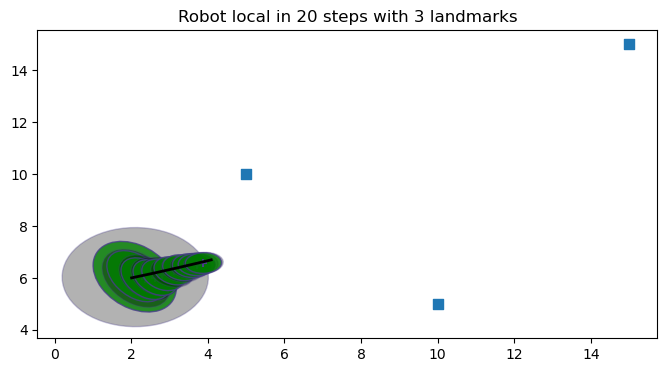

In [22]:
def plot_local_ekf(
    ax,
    dt,
    wheelbase,
    landmarks,
    std_vel,
    std_steer,
    std_range,
    std_bearing,
    std_ellipse=[6],
    step=10,
    ellipse_step=20,
    ylim=None,
):
    ekf = robot.RobotEKF(dt, wheelbase=wheelbase, std_vel=std_vel, std_steer=std_steer)
    ekf.x = np.array([[2, 6, 0.3]]).T  # x, y, steer angle
    ekf.P = np.diag([0.1, 0.1, 0.1])
    ekf.R = np.diag([std_range**2, std_bearing**2])
    sim_pos = ekf.x.copy()  # simulated position
    # steering command (vel, steering angle radians)
    u = np.array([1.1, 0.01])

    ax.scatter(landmarks[:, 0], landmarks[:, 1], marker="s", s=60)
    track = []
    for i in range(200):
        sim_pos = ekf.move(sim_pos, u, dt / 10.0)  # simulate robot
        track.append(sim_pos)

        if i % step == 0:
            ekf.predict(u=u)

            if i % ellipse_step == 0:
                plot_cov_ellipse_initial(
                    ax,
                    (ekf.x[0, 0], ekf.x[1, 0]),
                    ekf.P[0:2, 0:2],
                    std_ellipse,
                    "k",
                    0.3,
                )

            # x, y = sim_pos[0, 0], sim_pos[1, 0]
            for lmark in landmarks:
                z = robot.z_landmark(lmark, sim_pos, std_range, std_bearing)
                ekf.update(
                    z,
                    HJac=robot.HJac,
                    Hx=robot.Hx_1,
                    residual=robot.residual,
                    args=(lmark,),
                    hx_args=(lmark,),
                )

            if i % ellipse_step == 0:
                plot_cov_ellipse_initial(
                    ax,
                    (ekf.x[0, 0], ekf.x[1, 0]),
                    ekf.P[0:2, 0:2],
                    std_ellipse,
                    "g",
                    0.8,
                )

    track = np.array(track)
    ax.plot(track[:, 0], track[:, 1], color="k", lw=2)
    ax.set(title=f"Robot local in {ellipse_step} steps with {len(landmarks)} landmarks")
    if ylim is not None:
        ax.set(ylim=[*ylim])

    return ekf


landmarks = np.array([[5, 10], [10, 5], [15, 15]])

_, ax = plt.subplots(figsize=(8, 4))
ekf = plot_local_ekf(
    ax,
    dt,
    wheelbase=0.5,
    landmarks=landmarks,
    std_vel=0.1,
    std_steer=np.radians(1),
    std_range=0.3,
    std_bearing=0.1,
    std_ellipse=[6],
)
print(f"Final P: {ekf.P.diagonal()}")